## Feature Engineering, XGBoost and Allstate's Predicting Claims Severity Dataset

Having a predictive model builder that is explicitly manageable is of great value when managing decision risks. Having spent eleven years in the development of uncertainty management tools for continuous and categorical data in environmental planning, I witnessed how decision risks from data often can be reduced by simplifying interaction effects, simplifying models, and usually employing a dose of contextual lateral thinking from a field manager. This strategy was challenged when I explored the Allstate Claim's Severity car insurance dataset in 2017 (released in 2016 for a Kaggle competition.) I was attracted to it because I wanted to practice risk analysis with newer methods. I found:

1) One of the greatest learning benefits of working with an insurance dataset was the pre-processing challenges of a large database and visualizing relationships among data features during the exploratory phase. I felt, as many expressed, grateful that Allstate produced an enormous dataset for practitioners to explore their limits in the 2016 Kaggle competition on predicting claims severity. 

2) A predictive tool applied by top competition contenders was the machine learning tool XGBoost. XGBoost can be a highly accurate, flexible method of building decision trees. It makes it possible to control the problems of variance/bias with model building in a way that previous versions of boosting had not. It can be forgiving in the face of a large quantity blast of features, especially when not having time to fully explore or engineer those features. This may explain what the competitors were trying to understand in the race: can XGBoost rise to the occasion with a massive dataset - even not knowing anything real about the features other than the 'loss' category AND do so in a limited timeframe?

One can only guess what any column in the dataset represents. I demonstrate the importance of feature manipulation through a hypothesis of what one column may be. I do this because I believe grounded knowledge of the features is the quickest way to refining an XGBoost model, despite the amazing abilities of the tool for problem-solving Big Data issues for us. I manipulate one feature column, then use a cross-validated grid search to build and refine the model for predicting 'loss'. I compare the results to using the entire dataset. 

### EXPLORATORY DATA ANALYSIS

There are 116 categorical variables and 14 continuous variables. There are 188318 rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("C:\\Users\\Kristin\\train.csv")
train.shape

(188318, 132)

In [2]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


Allstate appears to have scaled all continuous variables, except the loss variable, between 0 to 1. The loss variable is skewed. Since I know I will rely on linear additive processes of XGBoost to help me understand data feature abundance, log transforming the loss variable is fundamental to building the regression model.

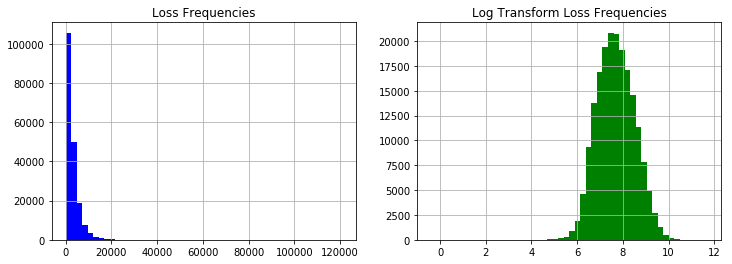

In [3]:
fig1, (axis1, axis2) = plt.subplots(1,2)
fig1.set_size_inches(12,4)
axis1.hist(train['loss'], bins=50, color='blue')
axis1.set_title('Loss Frequencies')
axis1.grid(True)
axis2.hist(np.log(train['loss']), bins=50, color='g')
axis2.set_title('Log Transform Loss Frequencies')
axis2.grid(True)
plt.show()

The continuous variables show some multi-collinearity. Using the default Pearson coefficient, a Seaborn heatmap is called to display the correlations.

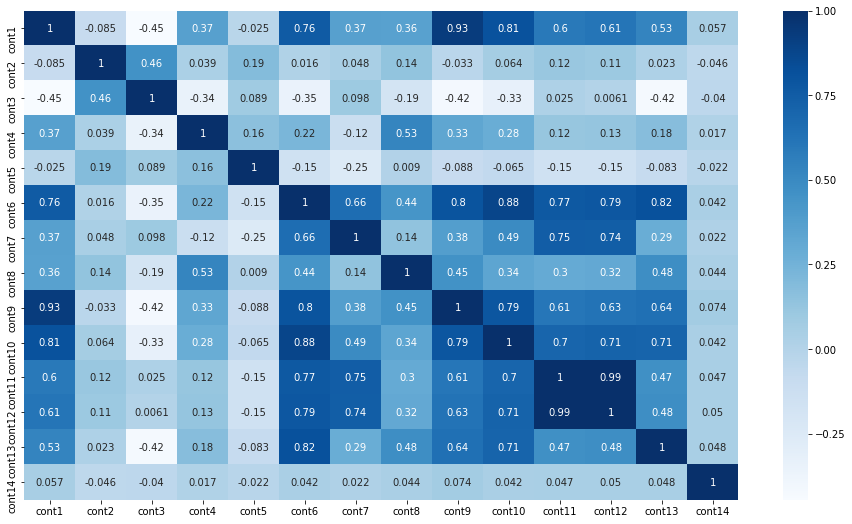

In [4]:
#identify features that are continuous vs categorical
cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss']]

#correlation matrix of continuous variables
import seaborn as sns
plt.subplots(figsize=(16,9))
correlation_mat = train[num_features].corr()
sns.heatmap(correlation_mat, cmap='Blues', annot=True)

I changed the heatmap display from the default colors to a single color scale because its better for people with colorblindness. 

Whether or not the outcome of a prediction model is impacted negatively by the collinearity is dependent on context. The meaning of loss predictions from a XGBoost decision trees would be misguided without more info. Realisticly, conclusions about even the most algorithmicly precise loss prediction model from this dataset cannot be drawn without this information.

The frequency counts for the codes in each categorical variable also are valuable. I want to thank dnkirill for posting how to extract and organize these in Python with Pandas. https://github.com/dnkirill/allstate_capstone

In [5]:
# Create an array of counts - each count is the number of unique values in a category
unique_vals = []
for cat in cat_features:
    unique_vals.append(len(train[cat].unique()))
# create a table of counts of unique values by category   
df_uniq_vals = pd.DataFrame.from_items([('cat_name', cat_features), ('unique_values', unique_vals)])
# now count how many categories have the same number of unique values
df_grouped = df_uniq_vals.groupby('unique_values').count()
df_grouped = df_grouped.rename(columns={'cat_name': 'categories'})
#sort from highest count to lowest counts
df_grouped.sort_values(by='categories', inplace=True, ascending=False)
df_grouped.reset_index(inplace=True)
print(df_grouped)

    unique_values  categories
0               2          72
1               4          12
2               3           4
3               7           4
4               5           3
5               8           3
6              20           2
7              19           2
8              17           2
9              16           2
10             15           1
11             13           1
12             11           1
13              9           1
14             23           1
15             51           1
16             61           1
17             84           1
18            131           1
19            326           1


While the majority of categorical variables are binary, a handful of those with the highest frequencies substantially add computational complexity to any regression analysis. The excitement of newer computational methods like XGBoost is its potential to assist managing this complexity numerically when developing Big Data models. The Allstate competition appears to ask for a single prediction model from this complexity with all categories UNKNOWN. The substantial difference in costs of insurance premiums in rural areas from urban cores presumably is because the risks are different, so this blind approach was puzzling at first.

Even not knowing the planning context where this generalized of a model is useful, it does appear that Allstate made the urban/rural distinction for us without telling us. In looking at the categorical variables, 'cat116' has 326 categories. There are 388 Metropolitan Statistical Areas (MSAs) in the U.S. Perhaps, Allstate provided only urban data. With the highest count of unique values in a categorical variable, 'cat116' poses multi-dimensional modeling complexity. One way to consciously control decision risks from models might be to assume different experiences among different geographies even if they are all urban. That would mean sub-setting the dataset by MSAs.

First, let's look at frequency counts within the 'cat116' variable:

In [6]:
# create a table of counts of unique values for 'cat116'
unique_vals = []
unique_vals=train['cat116'].unique()
df1 = train[['id','cat116']]
df_grouped = df1.groupby('cat116').count()
#sort from highest count to lowest count
df_grouped.sort_values(by='id', inplace=True, ascending=False)
df_grouped.reset_index(inplace=True)
print(df_grouped)

    cat116     id
0       HK  21061
1       DJ  20244
2       CK  10162
3       DP   9202
4       GS   8736
5       CR   6862
6       HX   5629
7       DC   4557
8       HG   4414
9       IE   4225
10      HQ   4044
11      HV   3853
12      GC   3803
13      LM   3277
14      LB   3194
15      LN   3127
16      KW   3085
17      HJ   2741
18      GK   2632
19      DF   2519
20      IG   2269
21      LO   2082
22      HB   2007
23      MD   1960
24      CB   1909
25      LF   1873
26      GI   1835
27      BY   1620
28      KC   1513
29      GE   1399
..     ...    ...
296     BB      1
297     MB      1
298     FN      1
299     FM      1
300     KH      1
301     FI      1
302     KS      1
303     FQ      1
304     EV      1
305     FS      1
306      G      1
307     EQ      1
308     DY      1
309     IR      1
310     DQ      1
311     JT      1
312     HO      1
313     JO      1
314     JN      1
315      C      1
316     HU      1
317     JK      1
318     JI      1
319     BL

Whether or not 'cat116' represents MSAs, I am able to show that managing this variable indeed matters when developing the model. I decided to subset the data by 'cat116' values. I decided to experiment with choosing values DJ, LM and GE to create 3 sample sizes of subset training data for building decision tree models. I compare the results to a researcher who used the entire dataset (most people in the top tier of the Allstate competition used the entire dataset or tried to manipulate the outliers. The competition required a single output model.)

### PREDICTIVE MODEL DEVELOPMENT WITH XGBOOST

There are multiple ways to optimize XGBoost performance when using it to build a predictive model. A few are: 1) feature manipulation 2) Bayesian optimization of parameters 3) Grid Search cross-validation sourcing of XGBoost model tuning parameters. After manipulating one feature column, I use the GridSearchCV method.

In [ ]:
import xgboost as xgb

#log transform skewed 'loss' variable for regression modelling
train['log_loss'] = np.log(train['loss'])

#create three sample subsets from the training data
train.set_index('cat116', inplace=True)

train_DJ = train.loc[['DJ']]
train_LM = train.loc[['LM']]
train_GE = train.loc[['GE']]

#dump master dataset from memory
del train

In [8]:
#create a list of all features to use in XGBoost 
features = [x for x in train_DJ.columns if x not in ['id', 'cat116','loss', 'log_loss']]

#create x values for each subset (the predictors)
train_DJx = train_DJ[features]
train_LMx = train_LM[features]
train_GEx = train_GE[features]

#remove 'cat116' from the categorical features list to prepare for label encoding
#of categorical variables
cat_features.remove('cat116')

#Encode variables in each subset using list of categorical features
for i in range(len(cat_features)):
    train_DJx[cat_features[i]] = train_DJx[cat_features[i]].astype('category').cat.codes
for i in range(len(cat_features)):
    train_LMx[cat_features[i]] = train_LMx[cat_features[i]].astype('category').cat.codes
for i in range(len(cat_features)):
    train_GEx[cat_features[i]] = train_GEx[cat_features[i]].astype('category').cat.codes

# transform the subsets to DMatrix, the data format of XGBoost -'log_loss' values are the target y values
dtrainDJ = xgb.DMatrix(train_DJx, train_DJ['log_loss'])
dtrainLM = xgb.DMatrix(train_LMx, train_LM['log_loss'])
dtrainGE = xgb.DMatrix(train_GEx, train_GE['log_loss'])

We are ready to train, tune and cross-validate XGBoost parameters. The most organized approach to tuning parameters I have found is demonstrated by https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/. The researcher dnkirill uses a similar approach on the full "Allstate Claims Severity" dataset, and I will compare my subset results to his performed on the complete dataset. 

Now we are ready to explore model development with XGBoost.
Step 1: Use general initial estimates of the parameters, including the default learning rate. Use the Cross-Validation approach to find an optimum number of trees for tuning parameters. In order to draw comparisons with dnkirill, I use the same parameters, including nfold=3, for those with less computing power.

In [9]:
from sklearn.metrics import mean_absolute_error
#set initial parameters - typical starting values are applied
#In linear regression, the outcome (dependent variable) is continuous. 
#and it can have any one of an infinite number of possible values
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

#Other typical values are run directly in the XGBoost function for the initial decision trees
#Mean absolute error is chosen as the default measure of the cross-validated rounds. Because the 
#target prediction values are log transformed, we use a custom python function that will translate the metric
#into backtransformed 'loss' values (dnkirill demonstrates this)
''' from dnkirill
https://github.com/dnkirill/allstate_capstone/blob/master/part2_xgboost.ipynb
'''
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

DJ_cv1 = xgb.cv(xgb_params, dtrainDJ, num_boost_round=50, nfold=3, seed=0, 
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

#Look at the lowest cross-validation score
DJ_cv1.iloc[-1,:]['test-mae-mean']

1154.3735349999999

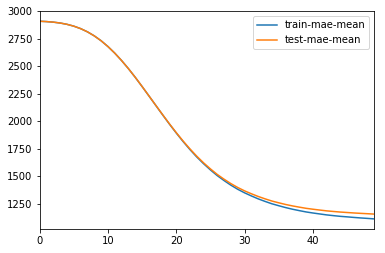

In [10]:
#plot the training and test errors for subset category DJ
plt.figure()
DJ_cv1[['train-mae-mean', 'test-mae-mean']].plot()

In [11]:
import requests
from ipywidgets import Image
#pulled from jupyter notebook: https://github.com/dnkirill/allstate_capstone/blob/master/part2_xgboost.ipynb
file = open("dnkirillsubplot2.png", "rb")
img = file.read()
Image(value=img,format='png',width=1000,height=350)

A Jupyter Widget

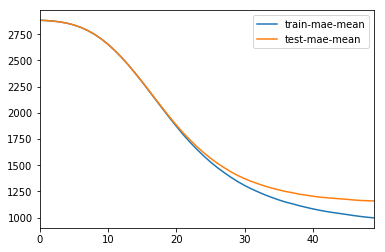

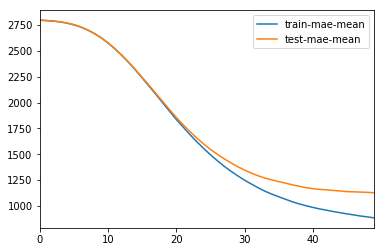

In [12]:
#Initial training model LM subset
LM_cv1 = xgb.cv(xgb_params, dtrainLM, num_boost_round=50, nfold=3, seed=0, 
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
#Look at lowest cross-validation score
LM_cv1.iloc[-1,:]['test-mae-mean']
#plot the training and test errors for subset category LM
plt.figure()
LM_cv1[['train-mae-mean', 'test-mae-mean']].plot()

#Initial training model GE subset
GE_cv1 = xgb.cv(xgb_params, dtrainGE, num_boost_round=50, nfold=3, seed=0, 
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
#Look at lowest cross-validation scores
GE_cv1.iloc[-1,:]['test-mae-mean']
#plot the training and test errors for subset category GE
plt.figure()
GE_cv1[['train-mae-mean', 'test-mae-mean']].plot()

### Step 1 Summary 

### PARAMETER TUNING XGBOOST

In [13]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from xgboostclass import XGBoostRegressor

#use a custom scorer which works with log-transformed values (from dnkirill and others in the competition)
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

#Set up ranges of max_depth and min_child_weight to tune
xgb_param_grid = {'max_depth': (5,6,7,8,9), 'min_child_weight': (5,6,7,8,9)}

#apply grid search method to apply XGBoost across a range of parameters
#what is the best trade-off between depth of trees and weights? Round 1
gridDJ = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
#the wrapper will convert x and y to the XGBoost Dmatrix format before fitting
gridDJ.fit(train_DJx, train_DJ['log_loss'])
#display score outputs
gridDJ.grid_scores_, gridDJ.best_params_, gridDJ.best_score_

([mean: -1151.85383, std: 9.39394, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -1151.97785, std: 9.04292, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -1152.74671, std: 9.24930, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -1151.01165, std: 9.04599, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: -1151.87573, std: 9.51633, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -1145.05325, std: 7.11896, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -1145.72490, std: 7.41791, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1145.01901, std: 8.76896, params: {'max_depth': 6, 'min_child_weight': 7},
  mean: -1143.50198, std: 9.34071, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: -1143.04359, std: 7.95952, params: {'max_depth': 6, 'min_child_weight': 9},
  mean: -1143.67451, std: 9.09927, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -1141.63264, std: 7.79613, params: {'max_depth': 7, 'min_child_weigh

In [14]:
#Tuning gamma to reduce overfitting
xgb_param_grid = {'gamma':[ 0.1,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,2,3]}
#run XGBoost with prior selections and the range of gamma values
gridDJ = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=7, min_child_weight=6,colsample_bytree=0.5,
                                       subsample=0.5), param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
#test fits
gridDJ.fit(train_DJx, train_DJ['log_loss'])
#View cross-validation scores
gridDJ.grid_scores_, gridDJ.best_params_, gridDJ.best_score_

([mean: -1141.61222, std: 8.13298, params: {'gamma': 0.1},
  mean: -1141.46408, std: 8.48432, params: {'gamma': 0.5},
  mean: -1140.39307, std: 8.45334, params: {'gamma': 0.6},
  mean: -1139.75976, std: 9.88837, params: {'gamma': 0.7},
  mean: -1138.38725, std: 8.00871, params: {'gamma': 0.8},
  mean: -1139.62010, std: 9.17259, params: {'gamma': 0.9},
  mean: -1139.62742, std: 9.30546, params: {'gamma': 1},
  mean: -1140.12252, std: 9.50858, params: {'gamma': 1.1},
  mean: -1141.49602, std: 7.38035, params: {'gamma': 1.2},
  mean: -1141.90567, std: 10.14090, params: {'gamma': 2},
  mean: -1150.17978, std: 9.92346, params: {'gamma': 3}],
 {'gamma': 0.8},
 -1138.3872467238798)

The mean absolute error decreases, hits a low point, and then it increases. This is good. Gamma is a complexity management value that we want to set before we move on to other parameters. It states a minimum loss value that must be reached before splitting a node in the decision tree. I will choose a value just before the lowest mean absolute error and choose gamma=0.6. 

Next, it is a good idea to re-check the number of boosting rounds. 

In [15]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 7,
    'min_child_weight': 6,
    'gamma': 0.6
}

DJ_cv2 = xgb.cv(xgb_params, dtrainDJ, num_boost_round=100, nfold=5, seed=2, 
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

#Look at the lowest cross-validation score
DJ_cv2.iloc[-1,:]['test-mae-mean']

1118.4688232000001

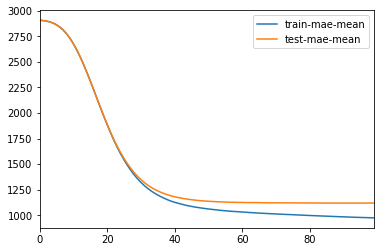

In [16]:
#plot the training and test errors for subset category DJ
plt.figure()
DJ_cv2[['train-mae-mean', 'test-mae-mean']].plot()

As we can see with this chart, our parameter choices have been safe. Now we will tune the fraction of observations to randomly sample for each tree ('subsample') and tune the fraction of columns to randomly sample for each tree ('colsample_bytree'). Again, we set up lists of parameters to test with the grid search cross-validation method.

In [17]:
xgb_param_grid = {'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gridDJ = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=7, min_child_weight=6, gamma=0.6), 
                      param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
gridDJ.fit(train_DJx, train_DJ['log_loss'])
gridDJ.grid_scores_, gridDJ.best_params_, gridDJ.best_score_

([mean: -1140.39307, std: 8.45334, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: -1138.28735, std: 11.05792, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: -1137.30937, std: 11.07059, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: -1138.61933, std: 10.19986, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: -1136.90100, std: 7.42706, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: -1138.34319, std: 12.00625, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: -1140.42165, std: 5.91341, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -1137.89802, std: 7.95734, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -1138.08420, std: 7.46774, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -1138.21757, std: 8.73812, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -1137.08125, std: 7.42601, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -1135.01771, std: 8.

I will test:
    mean: -1135.78750, std: 9.30819, params: {'colsample_bytree': 0.6, 'subsample': 0.9}. 
I charted the mean absolute errors to visualize the transitions. Running half steps, for example, 0.65 and 0.85 may have produced a better choice. 

Finally, we try to slow down the learning rate ('eta') to reduce the chance of overfitting. Again, we use the cross-validation function. As we try to drop the learning rate, we must increase the boosting rounds.

In [18]:
xgb_params = {
    'seed': 3,
    'eta': 0.01,
    'colsample_bytree': 0.6,
    'subsample': 0.9,
    'silent': 1, 
    'objective': 'reg:linear',
    'max_depth': 7,
    'min_child_weight': 6,
    'gamma': 0.6
}
DJ_cv3 = xgb.cv(xgb_params, dtrainDJ, num_boost_round=500, nfold=5, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=50)
DJ_cv3.iloc[-1,:]['test-mae-mean']

1136.6043946

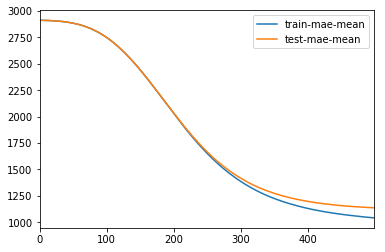

In [19]:
plt.figure()
DJ_cv3[['train-mae-mean', 'test-mae-mean']].plot()

In [24]:
xgb_params = {
    'seed': 3,
    'eta': 0.001,
    'colsample_bytree': 0.6,
    'subsample': 0.9,
    'silent': 1, 
    'objective': 'reg:linear',
    'max_depth': 7,
    'min_child_weight': 6,
    'gamma': 0.6
}
DJ_cv4 = xgb.cv(xgb_params, dtrainDJ, num_boost_round=10000, nfold=5, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=50)
DJ_cv4.iloc[-1,:]['test-mae-mean']

1104.2125243999999

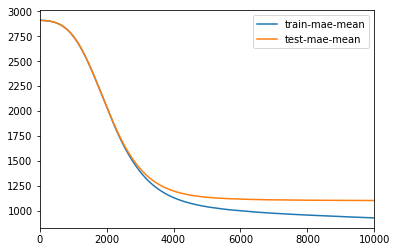

In [25]:
plt.figure()
DJ_cv4[['train-mae-mean', 'test-mae-mean']].plot()

The result of setting eta=0.001 and running 10,000 rounds was: 1104.212524  The plot of cross-validation scores for test and mean shows a steady decline in absolute error rates. It reaches 1104.21 between 5500 to 6000 rounds of boosting. With the regularization process, we reduce the risks of overfitting by managing the noisiness of the data. This takes computing time. 

While tuning earlier parameters, we have seen relatively small changes in the results.  Increasing the tuning parameter 'eta' eventually gives rise to bias. At the 5500 to 6000 boost range, test standard deviations are around 22 and training standard deviations around 3.6. Even though we have reduced the absolute error, we also have more than doubled the standard deviation in the error from running a starter 50 rounds. This standard deviation is similar to the 500 round model. We can now see, that in order to reduce the risk of bias in the final model choice, we would choose a model with less than 10,000 rounds.

Dnkirill's tests on the full dataset started with a cross-validated loss absolute mean score of 1219.57. After tuning, his final model came down to 1171.77 at 200 rounds. Our initial model model started at 1154.37, and after model tuning, reached 1104.21.  Note: Neither of us tested for local minima that may occur when setting sample rates at less than 0.5. 

### Next Steps 

In summary, having a model builder that is explicitly manageable is of great value when managing decision risks. I explored the value of simplifying categorical data when building a predictive model with XGBoost. XGBoost is a welcomed newer decision tree method because it handles complexity well, including the categorical variables with a high number of classes. Ultimately, however, I want to know the value of feature engineering on XGBoost in the Allstate Claims Severity dataset. The results of the competition seemed to suggest that the next step to improve the model is to produce ensemble machine learning approaches (for competition purposes only.) My question is whether reducing a categorical feature into fewer subcategories, would be more productive than putting all data into one Big Data model, e.g. what if 326 'types' were grouped into four 'types' and 4 predictive submodels were produced rather than one? The idea is that feature engineering is valuable for targeting loss values more precisely.  The robustness of XGBoost and the ability to manage the information on multiple levels of the model's development suggests connecting with managers on the ground and feature engineering as the next step rather than increasing computational model complexity. 